# Energy-based Models

**Author**: Chris Oswald

**Course**: CS676/ECE689 Advanced Topics in Deep Learning (Spring 2024)


## Question 4: Energy-based Models

- make a simple energy-based model (exp^-NN).
- train and apply any of the Monte Carlo samplings methods on USPS.

References:

- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html
- https://github.com/phlippe/uvadlc_notebooks/tree/master
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
models_dir = "./drive/MyDrive/Colab Notebooks/Models"
os.makedirs(models_dir, exist_ok=True)

## Imports and Datasets

In [ ]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torch.distributions.multivariate_normal import MultivariateNormal

import normflows as nf

import copy

%matplotlib inline

In [ ]:
# Import USPS data (reshaped to 16x16 and normalized to range [-1, 1])
ds_USPS  = torchvision.datasets.USPS(
    'USPS',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(16),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, ), (0.5, )), # Scale to [-1, 1]
    ])
)

100%|██████████| 6579383/6579383 [00:01<00:00, 3464054.87it/s]


In [ ]:
# Import Sampler class from https://github.com/phlippe/uvadlc_notebooks/tree/master
# Available under MIT license, Copyright (c) 2020 Phillip Lippe

# Importing class directly from Jupyter notebook is no longer working consistently
# (probably an issue on my end though)
try:
    os.chdir('/content')
    !git clone https://github.com/phlippe/uvadlc_notebooks.git
    os.chdir('/content/uvadlc_notebooks/docs/tutorial_notebooks/tutorial8')

    print(f'Attempting to import Deep_Energy_Models.Sampler using nbimporter')
    !pip install nbimporter
    from Deep_Energy_Models import Sampler

except ImportError:

    try:
        print(f'Attempting to import Deep_Energy_Models.Sampler using ipynb.fs.defs')
        !pip install ipynb
        from ipynb.fs.defs.Deep_Energy_Models import Sampler

    except SyntaxError:

        try:
            print(f'Attempting to import Deep_Energy_Models.Sampler using import_ipynb')
            !pip install import_ipynb
            from Deep_Energy_Models import Sampler

        except:
            print('All attempts unsuccessful...using static source code.')

            """
            Original source code from
            https://github.com/phlippe/uvadlc_notebooks/tree/master
            MIT license, Copyright (c) 2020 Phillip Lippe
            """
            import random

            class Sampler:

                def __init__(self, model, img_shape, sample_size, max_len=8192):
                    """
                    Inputs:
                        model - Neural network to use for modeling E_theta
                        img_shape - Shape of the images to model
                        sample_size - Batch size of the samples
                        max_len - Maximum number of data points to keep in the buffer
                    """
                    super().__init__()
                    self.model = model
                    self.img_shape = img_shape
                    self.sample_size = sample_size
                    self.max_len = max_len
                    self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

                def sample_new_exmps(self, steps=60, step_size=10):
                    """
                    Function for getting a new batch of "fake" images.
                    Inputs:
                        steps - Number of iterations in the MCMC algorithm
                        step_size - Learning rate nu in the algorithm above
                    """
                    # Choose 95% of the batch from the buffer, 5% generate from scratch
                    n_new = np.random.binomial(self.sample_size, 0.05)
                    rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
                    old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
                    inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

                    # Perform MCMC sampling
                    inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

                    # Add new images to the buffer and remove old ones if needed
                    self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
                    self.examples = self.examples[:self.max_len]
                    return inp_imgs

                @staticmethod
                def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
                    """
                    Function for sampling images for a given model.
                    Inputs:
                        model - Neural network to use for modeling E_theta
                        inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
                        steps - Number of iterations in the MCMC algorithm.
                        step_size - Learning rate nu in the algorithm above
                        return_img_per_step - If True, we return the sample at every iteration of the MCMC
                    """
                    # Before MCMC: set model parameters to "required_grad=False"
                    # because we are only interested in the gradients of the input.
                    is_training = model.training
                    model.eval()
                    for p in model.parameters():
                        p.requires_grad = False
                    inp_imgs.requires_grad = True

                    # Enable gradient calculation if not already the case
                    had_gradients_enabled = torch.is_grad_enabled()
                    torch.set_grad_enabled(True)

                    # We use a buffer tensor in which we generate noise each loop iteration.
                    # More efficient than creating a new tensor every iteration.
                    noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

                    # List for storing generations at each step (for later analysis)
                    imgs_per_step = []

                    # Loop over K (steps)
                    for _ in range(steps):
                        # Part 1: Add noise to the input.
                        noise.normal_(0, 0.005)
                        inp_imgs.data.add_(noise.data)
                        inp_imgs.data.clamp_(min=-1.0, max=1.0)

                        # Part 2: calculate gradients for the current input.
                        out_imgs = -model(inp_imgs)
                        out_imgs.sum().backward()
                        inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

                        # Apply gradients to our current samples
                        inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
                        inp_imgs.grad.detach_()
                        inp_imgs.grad.zero_()
                        inp_imgs.data.clamp_(min=-1.0, max=1.0)

                        if return_img_per_step:
                            imgs_per_step.append(inp_imgs.clone().detach())

                    # Reactivate gradients for parameters for training
                    for p in model.parameters():
                        p.requires_grad = True
                    model.train(is_training)

                    # Reset gradient calculation to setting before this function
                    torch.set_grad_enabled(had_gradients_enabled)

                    if return_img_per_step:
                        return torch.stack(imgs_per_step, dim=0)
                    else:
                        return inp_imgs


Cloning into 'uvadlc_notebooks'...
remote: Enumerating objects: 4502, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 4502 (delta 390), reused 437 (delta 356), pack-reused 3989
Receiving objects: 100% (4502/4502), 183.25 MiB | 29.56 MiB/s, done.
Resolving deltas: 100% (2976/2976), done.
Attempting to import Deep_Energy_Models.Sampler using nbimporter
Attempting to import Deep_Energy_Models.Sampler using ipynb.fs.defs
Attempting to import Deep_Energy_Models.Sampler using import_ipynb
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
All attempts unsuccessful...using static source code.


In [ ]:
# Specify convolutional neural network model architecture
class SwishAF(nn.Module):
    """Swish activation function."""

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNN(nn.Module):
    """
    Based on: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    and https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html
    """

    def __init__(self, input_channels: int, hidden_channels: int, out_dim: int) -> None:
        super().__init__()

        hidden_chan_1 = hidden_channels // 2
        hidden_chan_2 = hidden_channels
        hidden_chan_3 = hidden_channels * 2

        self.cnn_seq = nn.Sequential(
            nn.Conv2d(input_channels, hidden_chan_1, kernel_size=5, padding=2), # [16x16]
            SwishAF(),
            nn.Conv2d(hidden_chan_1, hidden_chan_1, kernel_size=5, padding=2), # [16x16]
            SwishAF(),
            nn.Conv2d(hidden_chan_1, hidden_chan_2, kernel_size=5, padding=2), # [16x16]
            SwishAF(),
            nn.Conv2d(hidden_chan_2, hidden_chan_2, kernel_size=5, padding=0), # [12x12]
            SwishAF(),
            nn.Conv2d(hidden_chan_2, hidden_chan_2, kernel_size=5, padding=0), # [8x8]
            SwishAF(),
            nn.Conv2d(hidden_chan_2, hidden_chan_3, kernel_size=5, padding=0), # [4x4]
            SwishAF(),
            nn.Conv2d(hidden_chan_3, hidden_chan_3, kernel_size=3, padding=0), # [2x2]
            SwishAF(),
            nn.Flatten(),
            nn.Linear(hidden_chan_3 * 2 * 2, hidden_chan_3),
            SwishAF(),
            nn.Linear(hidden_chan_3, out_dim),
        )

    def forward(self, x: torch.Tensor):
        output = self.cnn_seq(x).squeeze(dim=-1)
        return output

In [ ]:
# Specify energy model architecture
class EnergyModel():
    """
    Based on: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html
    (Available under MIT license, Copyright (c) 2020 Phillip Lippe)
    """

    def __init__(self, img_shape, batch_size, lr=1e-4, **CNN_kwargs):
        super().__init__()
        self.cnn = CNN(**CNN_kwargs)
        self.sampler = Sampler(self.cnn, img_shape, batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def compute_loss(self, real_imgs):
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Sample using MCMC sampler
        fake_imgs = self.sampler.sample_new_exmps(steps=40, step_size=10) #USPS images are 16x16 compared to 28x28 MNIST

        # Calculated predicted energy score
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate loss
        # regularized_loss = 0.1 * (real_out ** 2 + fake_out ** 2).mean()
        contrastive_div_loss = fake_out.mean() - real_out.mean()
        # loss = regularized_loss + contrastive_div_loss
        return contrastive_div_loss

    def save(self, path):
        torch.save(self.cnn.state_dict(), path)

    def load(self, path):
        self.cnn.load_state_dict(torch.load(path))

In [ ]:
# Create energy model
img_shape = tuple(ds_USPS[0][0].shape)
batch_size = 64
lr = 1e-4

model = EnergyModel(
    img_shape=img_shape,
    batch_size=batch_size,
    lr=lr,
    input_channels=img_shape[0],
    hidden_channels=32,
    out_dim=1
)
optimizer = optim.Adam(model.cnn.parameters(), lr=lr)

In [ ]:
# Load/train model
load_model = False
load_model_name = ""
load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(load_model_path))
    else:
        model.load_state_dict(
            torch.load(load_model_path, map_location=torch.device("cpu"))
        )
else:
    epochs = 20

    dl = DataLoader(ds_USPS, batch_size=batch_size, shuffle=True, drop_last=True)
    size = len(dl.dataset)

    lowest_abs_loss = None # Note that we want abs(loss) to be close to 0 for this model

    model.cnn.to(device)
    model.cnn.train()
    for t in range(epochs):
        batch_losses = []
        for batch_idx, (real_imgs, _) in enumerate(dl):
            real_imgs = real_imgs.to(device)

            # Compute loss
            loss = model.compute_loss(real_imgs)

            if ~(torch.isnan(loss) | torch.isinf(loss)):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Record training batch loss
                loss_val = loss.item()
                batch_losses.append(loss_val)

        epoch_avg_loss = np.mean(batch_losses)
        print(f"Loss: {epoch_avg_loss:>7f} [Epoch {t+1}/{epochs}]")

        # Save model if improving
        if (lowest_abs_loss is None) or (abs(epoch_avg_loss) < lowest_abs_loss):
            lowest_abs_loss = abs(epoch_avg_loss)
            model.save(os.path.join(models_dir, f'EnergyModel_epoch{t+1}.pt'))
            print(f'Saved model for epoch {t+1}')

Loss: -0.003738 [Epoch 1/20]
Saved model for epoch 1
Loss: -0.000868 [Epoch 2/20]
Saved model for epoch 2
Loss: 0.000140 [Epoch 3/20]
Saved model for epoch 3
Loss: 0.000124 [Epoch 4/20]
Saved model for epoch 4
Loss: -0.000141 [Epoch 5/20]
Loss: -0.000370 [Epoch 6/20]
Loss: -0.000151 [Epoch 7/20]
Loss: 0.000059 [Epoch 8/20]
Saved model for epoch 8
Loss: -0.000017 [Epoch 9/20]
Saved model for epoch 9
Loss: 0.000259 [Epoch 10/20]
Loss: -0.000383 [Epoch 11/20]
Loss: 0.000125 [Epoch 12/20]
Loss: -0.000194 [Epoch 13/20]
Loss: -0.000046 [Epoch 14/20]
Loss: 0.000307 [Epoch 15/20]
Loss: -0.000242 [Epoch 16/20]
Loss: 0.000044 [Epoch 17/20]
Loss: -0.000119 [Epoch 18/20]
Loss: -0.000055 [Epoch 19/20]
Loss: 0.000134 [Epoch 20/20]


In [ ]:
# Generate samples
model.cnn.eval()
n_samples = 1
start_imgs = torch.rand((n_samples, ) + img_shape).to(device)
start_imgs = start_imgs * 2 - 1 # Normalize to range [-1, 1]
torch.set_grad_enabled(True) # Set to True for sampling
imgs_per_step = Sampler.generate_samples(
    model.cnn,
    start_imgs,
    steps=100,
    step_size=10,
    return_img_per_step=True,
)

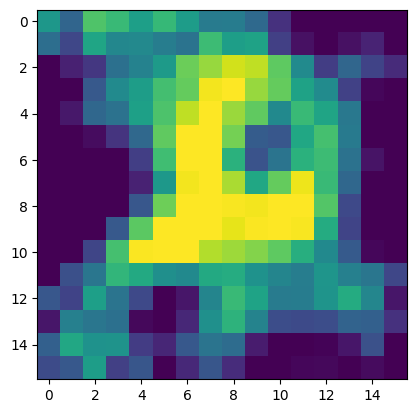

In [ ]:
# Generated image
plt.imshow(imgs_per_step.squeeze()[-1].detach().to("cpu"))